Import Library

In [119]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import os
import glob
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Preprocessing Data

In [120]:
class tablechair(Dataset):

    def __init__(self, root_dir, random_seed=42, image_size=224):

        self.root_dir = root_dir
        self.image_size = image_size

        if not os.path.exists(self.root_dir):
            raise RuntimeError(f"Dataset not found at {self.root_dir}.")

        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.data = []
        self.labels = []

        for label, class_name in tqdm(enumerate(['table', 'chair'])):
            class_dir = os.path.join(self.root_dir, class_name)
            image_paths = glob.glob(os.path.join(class_dir, '*.jpg'))
            self.data.extend(image_paths)
            self.labels.extend([label] * len(image_paths))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

Memasukkan Transfer Learning

In [121]:
batch_size = 32
test_batch_size = 32
train_dataset = tablechair(root_dir='/kaggle/input/table-and-chair/Tugas 4/Train')
test_dataset  = tablechair(root_dir='/kaggle/input/table-and-chair/Tugas 4/Test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
num_features = model.classifier[1].in_features
num_classes_output = 2
model.classifier[1] = nn.Linear(in_features=num_features, out_features=num_classes_output)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

2it [00:00, 1425.18it/s]
2it [00:00, 10686.12it/s]

cuda


In [122]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")

Total parameters: 2.23M
Trainable parameters: 2.23M


Training Model

In [123]:
num_epoch = 10
train_losses = []
test_losses = []

for epoch in range(num_epoch):
    model.train()
    train_loss = 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)

    model.eval()

    correct = 0
    total = 0
    test_loss = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)

            loss = criterion(outputs, labels)
            test_loss += loss.item() * data.size(0)

            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()

            total += labels.size(0)

    acc = correct / total if total > 0 else 0
    avg_train_loss = train_loss / len(train_dataset) if len(train_dataset) > 0 else 0
    avg_test_loss = test_loss / len(test_dataset) if len(test_dataset) > 0 else 0

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Test Loss {avg_test_loss:.4f}, Test Acc {acc:.4f}")


Epoch 1: Train Loss 0.6124, Test Loss 0.0000, Test Acc 0.0000
Epoch 2: Train Loss 0.3558, Test Loss 0.0000, Test Acc 0.0000
Epoch 3: Train Loss 0.2101, Test Loss 0.0000, Test Acc 0.0000
Epoch 4: Train Loss 0.1231, Test Loss 0.0000, Test Acc 0.0000
Epoch 5: Train Loss 0.0788, Test Loss 0.0000, Test Acc 0.0000
Epoch 6: Train Loss 0.0532, Test Loss 0.0000, Test Acc 0.0000
Epoch 7: Train Loss 0.0385, Test Loss 0.0000, Test Acc 0.0000
Epoch 8: Train Loss 0.0317, Test Loss 0.0000, Test Acc 0.0000
Epoch 9: Train Loss 0.0244, Test Loss 0.0000, Test Acc 0.0000
Epoch 10: Train Loss 0.0205, Test Loss 0.0000, Test Acc 0.0000


In [124]:
torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'test_loss': test_losses,
}, 'table_chair_checkpoint.pth')

Evaluasi

In [125]:
def evaluate_model(model, dataloader, device):
    """
    Mengevaluasi performa model dan menampilkan confusion matrix beserta classification report.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())    


    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"Akurasi pada data uji: {acc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, labels=[0,1], target_names=['chair', 'table']))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0,1])

    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['chair', 'table'], yticklabels=['chair', 'table'])

    plt.xlabel("Predicted")


Akurasi pada data uji: nan

Classification Report:
              precision    recall  f1-score   support

       chair       0.00      0.00      0.00       0.0
       table       0.00      0.00      0.00       0.0

   micro avg       0.00      0.00      0.00       0.0
   macro avg       0.00      0.00      0.00       0.0
weighted avg       0.00      0.00      0.00       0.0

Confusion Matrix:
[[0 0]
 [0 0]]


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:

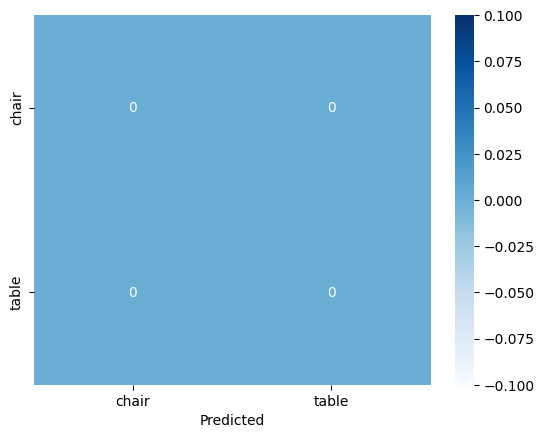

In [126]:
evaluate_model(model, test_loader, device)

Visualisasi

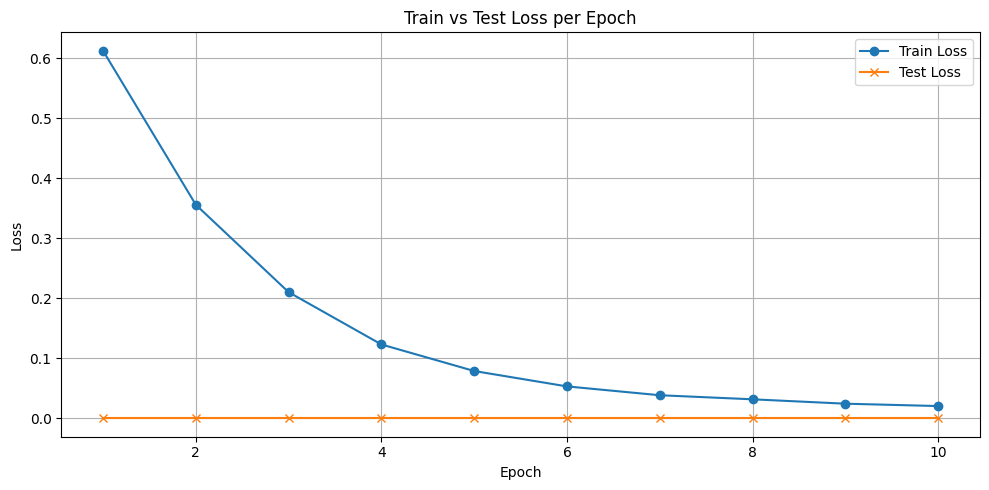

In [127]:
epochs = range(1, num_epoch + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [128]:
def load_model(weight_path, num_classes, device):
    checkpoint = torch.load(weight_path, map_location=device)

    model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)

    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    return model

In [129]:
def predict_image(image_path, model, device, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, pred = torch.max(outputs, 1)

    predicted_class = class_names[pred.item()]
    return predicted_class, image

Testing

Prediction: chair


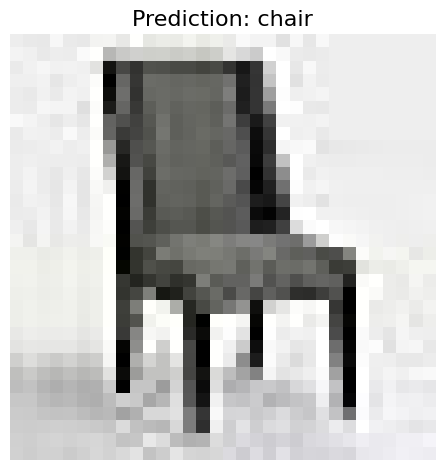

In [130]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    class_names = ['chair','table']

    model = load_model('/kaggle/working/table_chair_checkpoint.pth', num_classes=len(class_names), device=device)

    img_path = '/kaggle/input/table-and-chair/Tugas 4/kursi (139).jpg'
    predicted_label, image = predict_image(img_path, model, device, class_names)

    print(f"Prediction: {predicted_label}")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}", fontsize=16)
    plt.tight_layout()
    plt.show()

Prediction: table


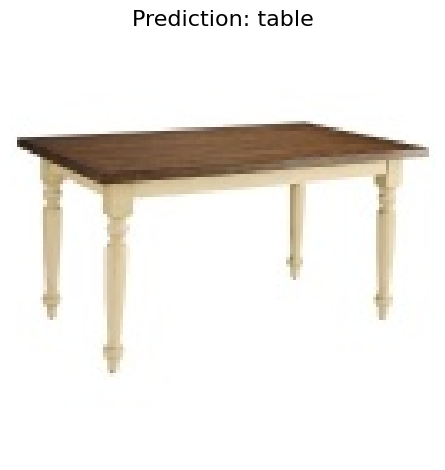

In [131]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Gantilah dengan label sesuai urutan di dataset ImageFolder
    class_names = ['table', 'chair']

    # Load model
    model = load_model('table_chair_checkpoint.pth', num_classes=len(class_names), device=device)

    # Ganti path gambar sesuai kebutuhan
    img_path = '/kaggle/input/table-and-chair/Tugas 4/Table (100).jpg'
    predicted_label, image = predict_image(img_path, model, device, class_names)

    print(f"Prediction: {predicted_label}")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}", fontsize=16)
    plt.tight_layout()
    plt.show()